# Predicting House Sale Prices

- **Dataset**: Sales from 2006-2010 in the city of Ames, Iowa, USA

- **data collection** info: [link](https://doi.org/10.1080/10691898.2011.11889627) 
The data set contains 2930 observations and a large number of explanatory variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous)

- **columns info**:[link](https://s3.amazonaws.com/dq-content/307/data_description.txt)

Using the sales data from the past we will try to establish a model that can predict the price for houses. An exemple of this project is [available](https://github.com/dataquestio/solutions/blob/master/Mission240Solutions.ipynb).

The project will be done as follow:
- data cleaning and features engineering 
- features selection
- train
- test 
- production (in the future when I know how to do that)


## Data preparation

In [2]:
import pandas as pd
pd.options.display.max_rows = 999
import matplotlib.pyplot as plt
%matplotlib inline
import math
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
#import csv
raw_sales=pd.read_csv('AmesHousing.tsv',delimiter='\t')

###### train validation test sets 60 20 20%

The validation set is used to validate the model, once a final model has been created will be tested on a test set for real measure.

In [91]:
def split_dataset(df):
    #split train test set 
    train,test_validation = train_test_split(df, test_size = 0.4, random_state = 0)

    #split test set into the validation and test set
    validation, test = train_test_split (test_validation,test_size=0.5, random_state=0)
    
    return train, validation, test

In [5]:
train, validation, test = split_dataset(raw_sales)

print(train.shape, validation.shape, test.shape)

(1758, 82) (586, 82) (586, 82)


###### General functions

In [6]:
#it will contain every transfo we do on the training set will be done also to the test and validation set
def transform_features(df):
    return train

In [7]:
def select_features(df):
    return df[['Gr Liv Area','SalePrice']]

In [8]:
def train_and_test(df, features,target=['SalePrice']):
    
    lr= LinearRegression()
    X = df[features]
    y= df[target]
    lr.fit(X,y)
    train_predictions = lr.predict(X)
    test_predictions = lr.predict(test[features])
    
    rmse = np.sqrt(mean_squared_error(test_predictions, test[target]))
    
    print('score train set:',lr.score(X,y))
    print('score test set:', lr.score(test[features],test[target]))
    print('rmse:', rmse)
    
    return rmse

### Crude model 
For a linear regression, it needs data without missing value and numeric
- let's build a model without any features enginnering to have our baseline to quantify our improvement after

In [9]:
numeric_cols = train.select_dtypes('number').columns

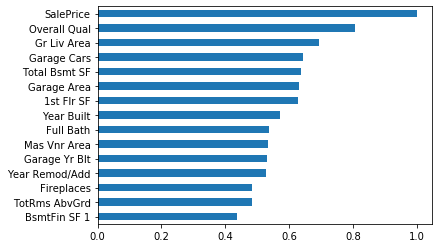

In [10]:
train[numeric_cols].corr()['SalePrice'].abs().sort_values().tail(15).plot.barh()

- the "overall quality feature" has high correlation Overall Qual: "Rates the overall material and finish of the house"

        IMO we should not use for the model has it  already leaks toward the target column the price and is not a continuous feature

- The next is Gr Liv Area : "Above grade (ground) living area square feet" so how big is the house above grand explain like 65% of the SalePrice. 

=>**Let'us this feature as our baseline model.**


In [92]:
#baseline score and rmse of our linear model 
train_and_test(train,['Gr Liv Area'])

score train set: 0.4856574021331867
score test set: 0.5583901646922056
rmse: 59093.76159983195


59093.76159983195

- Our first estimationThe results are not super good, let's see if we can improve them with some feature engineering or by adding more features
there is a correlation with the garage information so we should try to investigate a bit there

## Features Engineering (and data cleaning)
- remove any columns which:

    - has more than 5% of missing value 
    - can leak data info the price such as the year the sale took place or the overall condition 
- transform non numeric categories to something exploitable (dummy coding)
- create new features such as age house or when was it last refurbished?

- ###### col with >5% missing values

In [12]:
#what columns have more than 5% missing values
lot_missing_values=raw_sales.isnull().sum() / raw_sales.shape[0] 

#list columns
col_lot_missing_values=raw_sales.columns[lot_missing_values > 0.05]

#drop columns
raw_sales.drop(col_lot_missing_values,axis=1,inplace=True)

######  cleaning and creature new features
- among the rest of the missing value, 

    - create feature for the age of the house and how long it has been since the last modification /addition 
    - Mas Vnr  Area, 23 where there is none so we can just keep for the categorical and for the area we put 0 as it is the mode of the col.
    - Mas Vnr  Type, as we put 0 In the area it means we consider that there is no Mas Vnr so we fill up these nan with 'None'
    - Basement: the house where there are no basement: value to 'no_basement' the rest we drop (less than 5)
    
    - then let drops the rest as it is only a few rows (15 so less than 0.5% of the entier dataset)

In [13]:
raw_sales['Mas Vnr Type'].fillna('None',inplace=True)
raw_sales['Mas Vnr Area'].fillna(0,inplace=True)

raw_sales[['Bsmt Qual','Bsmt Cond']]= raw_sales[['Bsmt Qual','Bsmt Cond']].fillna('None')

#fixing basement related columns
#find the index of where there no basement => means also no exposure
index = raw_sales[raw_sales['Bsmt Qual']=='None']['Bsmt Exposure'].index
#then fix the value from 'nan' to 'no_basement'
raw_sales.loc[index,['Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2']]='None'


raw_sales.dropna(inplace=True)

#create new features
raw_sales['age_when_sold'] = raw_sales['Yr Sold'] - raw_sales['Year Built']
raw_sales['last_modif_add'] = raw_sales['Yr Sold'] - raw_sales['Year Remod/Add']

raw_sales.drop(['Year Built','Year Remod/Add'],inplace=True,axis=1)

- update the numeric cols list 

In [14]:
numeric_cols = raw_sales.select_dtypes('number').columns

In [15]:
raw_sales[['age_when_sold','last_modif_add']].describe()

,age_when_sold,last_modif_add
count,2922.000000,2922.000000
mean,36.461328,23.556810
std,30.284490,20.856785
min,-1.000000,-2.000000
25%,7.000000,4.000000
50%,34.000000,15.000000
75%,54.000000,43.000000
max,136.000000,60.000000


- there are some negative values in the columns age_when_sold and last_modif_add so we remove the corresponding rows

In [16]:
#find their index to remove it 
print(raw_sales[raw_sales['age_when_sold']<0]['age_when_sold'])
print(raw_sales[raw_sales['last_modif_add']<0]['last_modif_add'])

#then drop it
raw_sales.drop(index=[2180,1702,2181],inplace=True,axis=0)

2180   -1
Name: age_when_sold, dtype: int64
1702   -1
2180   -2
2181   -1
Name: last_modif_add, dtype: int64


###### col with high corr with Sale Price

/Users/thibaud/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


Text(0.5, 1, 'Feature with corr > 0.4  with target column SalePrice')

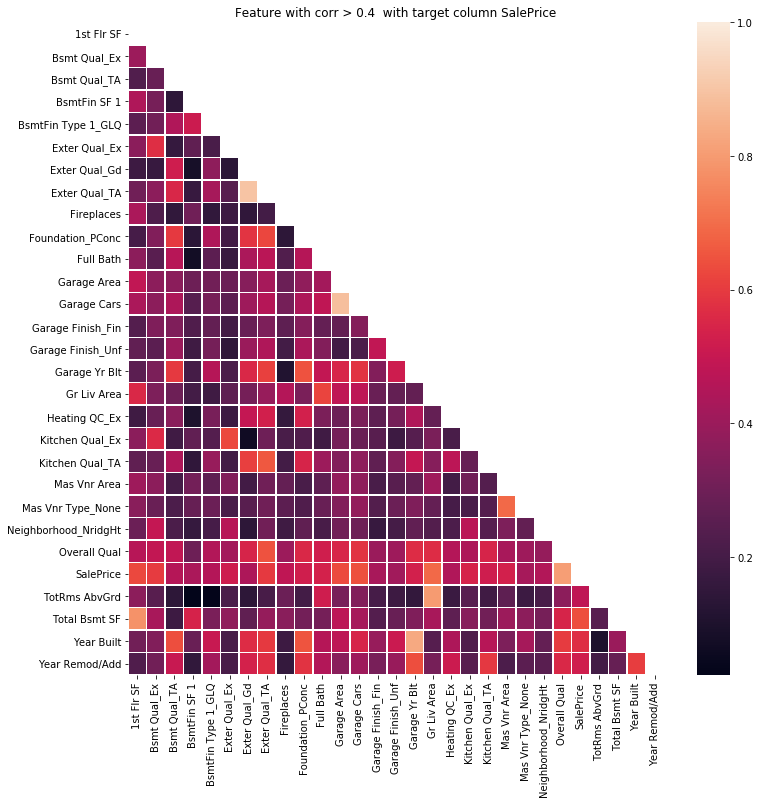

In [39]:
# we set up a treshold to 0.4 correlation
thres_corr=0.4
high_corr_cols_mask=raw_sales[numeric_cols].corr().abs()['SalePrice'] >thres_corr
high_corr_cols = raw_sales.corr().sort_index().abs()[high_corr_cols_mask]

plt.figure(figsize=(12,12))
mask = np.zeros_like(high_corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(high_corr,
            linewidths=.5,
            mask=mask)
plt.title('Feature with corr > %a  with target column SalePrice' %thres_corr)

In [51]:
#list cols with 
high_corr_cols.index

Index(['1st Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Full Bath', 'Garage Area',
       'Garage Cars', 'Gr Liv Area', 'Mas Vnr Area', 'Overall Qual',
       'SalePrice', 'TotRms AbvGrd', 'Total Bsmt SF', 'age_when_sold',
       'last_modif_add'],
      dtype='object')

In [93]:
#how to control the improvement with the col having > 0.4 corr with sale price
train, validation, test = split_dataset(raw_sales)
#we drop the cols SalePrice and Garage Cars (duplicate info with Garage Area)
train_and_test(train,['1st Flr SF', 'BsmtFin SF 1', 'Fireplaces', 'Full Bath', 'Garage Area',
                      'Gr Liv Area', 'Mas Vnr Area', 'Overall Qual', 'TotRms AbvGrd', 'Total Bsmt SF', 'age_when_sold','last_modif_add'])

score train set: 0.8207855868317416
score test set: 0.8470873166310583
rmse: 34773.14903754771


34773.14903754771

- incorporing more features improved the models 
- let's investigate the categorical columns


#### Categorical features

- during our data cleaning, the categorical columns 'Misc Feature', 'Garage Type', 'Alley' were removed 
- removing PID cause too many category value
- we will dummy coding on col with not too many categories

In [138]:
#category col according to the columns info documents
categorical_cols = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
for col in ['Misc Feature', 'Garage Type', 'Alley','PID']:
    categorical_cols.remove(col)

In [133]:
#number of uniques in the different categorical 
raw_sales[categorical_cols].apply(lambda column: len(column.value_counts()))


MS SubClass       16
MS Zoning          7
Street             2
Land Contour       4
Lot Config         5
Neighborhood      28
Condition 1        9
Condition 2        8
Bldg Type          5
House Style        8
Roof Style         6
Roof Matl          8
Exterior 1st      16
Exterior 2nd      17
Mas Vnr Type       5
Foundation         6
Heating            6
Central Air        2
Sale Type         10
Sale Condition     6
dtype: int64

In [142]:
 for  col in [categorical_cols]:
        print(col)

['MS SubClass', 'MS Zoning', 'Street', 'Land Contour', 'Lot Config', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Heating', 'Central Air', 'Sale Type', 'Sale Condition']


- the number of categories seems fine let's do the dummy coding and remove the original ones

In [166]:
for col in [categorical_cols]:
    dummies= pd.get_dummies(raw_sales[col])
    raw_sales_dummies= pd.concat([raw_sales,dummies],axis=1)
    #remove original col
    raw_sales_dummies.drop(col,axis=1,inplace=True)
    

In [179]:
raw_sales_dummies.corr().abs()['SalePrice'].sort_values().tail(14)

Neighborhood_NridgHt    0.433160
BsmtFin SF 1            0.439981
TotRms AbvGrd           0.497858
Mas Vnr Area            0.507115
Foundation_PConc        0.522452
last_modif_add          0.534717
age_when_sold           0.559245
1st Flr SF              0.637681
Garage Area             0.641303
Total Bsmt SF           0.646783
Garage Cars             0.648154
Gr Liv Area             0.718524
Overall Qual            0.801956
SalePrice               1.000000
Name: SalePrice, dtype: float64

In [207]:
cols=raw_sales_dummies.corr().abs()['SalePrice'].sort_values().tail(14).index
cols= list(cols)
cols.remove('SalePrice')


In [208]:
train, validation, test = split_dataset(raw_sales_dummies)

In [209]:
for i in range(len(cols)):
    train_and_test(train,cols[:i+1])

score train set: 0.20332132468416242
score test set: 0.17010630777014069
rmse: 81009.04250237651
score train set: 0.3398292871020522
score test set: 0.3266268416647766
rmse: 72970.97809919289
score train set: 0.5111024415728225
score test set: 0.5272186347895164
rmse: 61143.802302223536
score train set: 0.5497487457753996
score test set: 0.5730881247802098
rmse: 58102.040525413264
score train set: 0.6405856411952687
score test set: 0.6657134533702577
rmse: 51414.038277517204
score train set: 0.6786925578700722
score test set: 0.6964314951161814
rmse: 48994.87150393293
score train set: 0.68939176026879
score test set: 0.7038575120528477
rmse: 48391.89481283151
score train set: 0.7249976300172111
score test set: 0.7542603443699147
rmse: 44081.857856880924
score train set: 0.7488478323112555
score test set: 0.7595364910059758
rmse: 43606.06093414143
score train set: 0.7514973170254523
score test set: 0.7649998066357832
rmse: 43107.851387824085
score train set: 0.7538504338647698
score tes

Text(0.5, 1, 'Correlation numeric features with target column SalePrice')

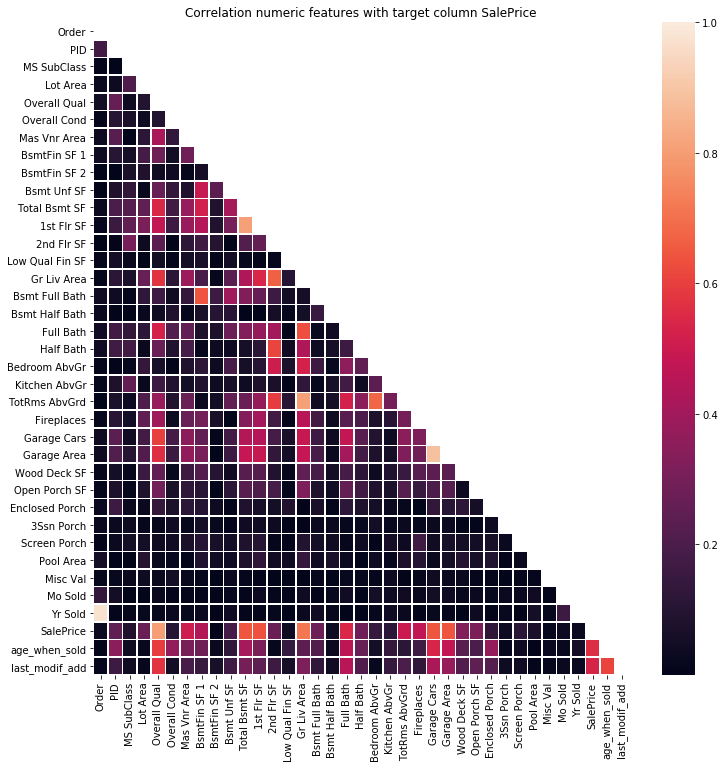

In [20]:
plt.figure(figsize=(12,12))
high_corr=raw_sales.sort_index().corr().abs()
mask = np.zeros_like(high_corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(high_corr,
            linewidths=.5,
            
            mask=mask)
plt.title('Correlation numeric features with target column SalePrice')

among the cols that can predict the target col, are they ones with colinearity

- identify the col with high corr with sales price, extract these columns then recompute the correlation among them to identify colinearity

In [21]:
df_dummies=pd.get_dummies(train)

In [22]:
high_corr_cols=df_dummies.select_dtypes('number').corr().abs()['SalePrice'][df_dummies.select_dtypes('number').corr().abs()['SalePrice'] > 0.4].index.sort_values()

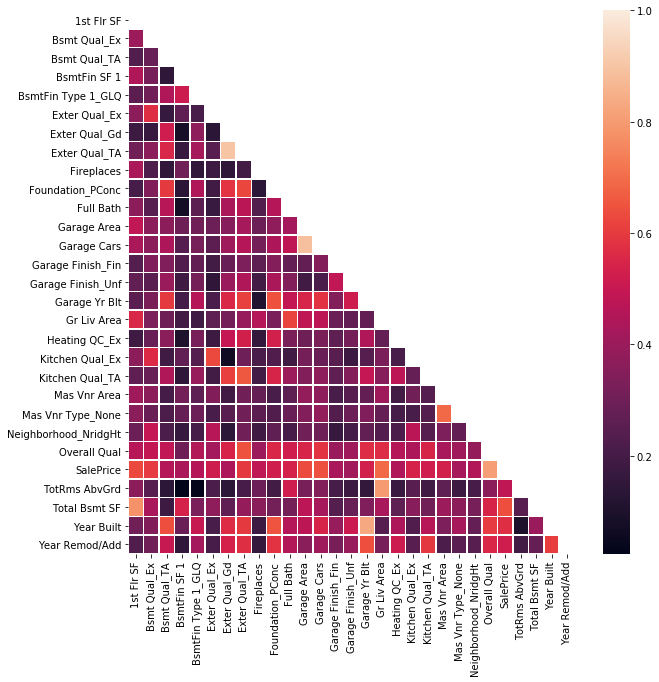

In [23]:
plt.figure(figsize=(10,10))

high_corr=df_dummies[high_corr_cols].corr().abs()
mask = np.zeros_like(high_corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(high_corr,
            linewidths=.5,
            
            mask=mask)

In [24]:
#model with dummies
list_cols= df_dummies.select_dtypes('number').corr().abs()['SalePrice'][df_dummies.select_dtypes('number').corr().abs()['SalePrice'] > 0.4].sort_values(ascending=False).index
list_cols.drop('SalePrice')
list_cols = list(list_cols[1:-1])
print(list_cols)

['Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Total Bsmt SF', 'Garage Area', '1st Flr SF', 'Bsmt Qual_Ex', 'Exter Qual_TA', 'Year Built', 'Kitchen Qual_Ex', 'Full Bath', 'Mas Vnr Area', 'Garage Yr Blt', 'Year Remod/Add', 'Foundation_PConc', 'Kitchen Qual_TA', 'Exter Qual_Ex', 'Fireplaces', 'TotRms AbvGrd', 'Bsmt Qual_TA', 'BsmtFin Type 1_GLQ', 'Neighborhood_NridgHt', 'Heating QC_Ex', 'Exter Qual_Gd', 'BsmtFin SF 1', 'Garage Finish_Fin', 'Mas Vnr Type_None']


In [25]:
train_and_test(df_dummies, ['Overall Qual','Gr Liv Area', 'Total Bsmt SF', 
                            '1st Flr SF', 'Exter Qual_TA', 'Bsmt Qual_Ex', 'age_when_sold', 
                            'Full Bath', 'Kitchen Qual_Ex', 'last_modif_add', 
                            'Foundation_PConc', 'Mas Vnr Area', 'TotRms AbvGrd', 'Fireplaces', 
                            'Exter Qual_Ex', 'BsmtFin Type 1_GLQ', 'Exter Qual_Gd', 'Heating QC_Ex', 
                            'Neighborhood_NridgHt', 'Bsmt Qual_TA', 'BsmtFin SF 1'])

KeyError: "['age_when_sold', 'last_modif_add'] not in index"

In [ ]:
rmses=list()
select_features=list()
for feature in list_cols:
    select_features.append(feature)
    print(select_features)
    rmse=train_and_test(df_dummies,[select_features])
    rmses.append(rmse)
    print('the rmse is ',rmse)

In [ ]:
plt.scatter(x=range(24),y=rmses)

In [ ]:
#select columns with high correlation with Sale Price
train[numeric_cols].corr().abs()['SalePrice'][train[numeric_cols].corr().abs()['SalePrice'] > 0.4].sort_values().index

In [ ]:
#test model without dummies
a=train_and_test(train,['BsmtFin SF 1', 'Mas Vnr Area', 'Fireplaces',
       'last_modif_add', 'Full Bath', 'age_when_sold', '1st Flr SF',
       'Total Bsmt SF', 'Garage Cars'
                     ])

In [ ]:
rmses=[]
for i in range(25):
    select_features=list_cols[i]
    rmse=train_and_test(df_dummies,[select_features])
    rmses.append(rmse)

plt.plot(x=range(24))

In [ ]:
rmses

In [ ]:
ax=plt.figure(figsize=(15,15))

corr=train[numeric_cols].corr().abs()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,
           linewidths=.5,
           mask=mask,
           )


### Categorical features

In [ ]:
#fix type for categorical columns according to the 
categorical_cols = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

- some categorical columns have been already removed

In [ ]:
#['Misc Feature', 'Alley', 'Garage Type'] already not there
for col in ['Misc Feature', 'Alley', 'Garage Type']:
    categorical_cols.remove(col)

In [ ]:
 raw_sales['Mas Vnr Type'].astype('category')

In [ ]:
for col in categorical_cols:
    raw_sales[col] = raw_sales[col].astype('category')

In [ ]:
pd.get_dummies(train).corr()['SalePrice'].sort_index